In [23]:
from typing import Tuple, List, Dict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import (alexnet,
                                AlexNet_Weights,
                                resnet18,
                                ResNet18_Weights,
                                ResNet,
                                resnet101)

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np



In [24]:
class NeuralImageCompressor(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 normalising_activation: nn.Module = nn.Sigmoid(),
                 B: int = 1):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.normalising_activation = normalising_activation
        self.B = B
            
    def _get_quantization_error(self, shape: Tuple[int, ...]):
        mean = torch.full(shape, -0.5)
        std = torch.full(shape, 0.5)
        quan_err = 0.5**self.B * torch.normal(mean = mean, std = std)
        return quan_err
    
    def freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False
    
    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.normalising_activation(out)
        quant_err = self._get_quantization_error(out.shape).to(out.device)
        out = out + quant_err
        out = self.decoder(out)
        return out

In [25]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [30]:
class SequentialDecoder8x(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_chan_nums = [512, 256, 128, 64, 3]
        
        decoder_modules = []

        for out_channels in out_chan_nums:
            decoder_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels, out_channels, kernel_size=2, stride=2
                    ),
                    DoubleConv(in_channels=out_channels, out_channels=out_channels),
                )
            )
            in_channels = out_channels

        self.decoder = nn.Sequential(*decoder_modules)
    
    def forward(self, img: torch.Tensor):
        return self.decoder(img)

In [31]:
# def simple_decoder_8x_upsample_constructor(in_chan_num):
#     out_chan_nums = [512, 256, 128, 64, 3]

#     decoder_modules = []

#     for out_chan_num in out_chan_nums:
#         decoder_modules.append(
#             nn.Sequential(
#                 nn.Upsample(
#                     scale_factor=2,
#                     mode='nearest'
#                 ),
#                 nn.Conv2d(in_channels=in_chan_num,
#                           out_channels=out_chan_num,
#                           kernel_size=3, stride=1, padding=1),
#                 nn.ReLU()
#             )
#         )

#         in_chan_num = out_chan_num
    
#     return nn.Sequential(*decoder_modules)

In [32]:
def resnet_encoder_constructor(resnet):
    return nn.Sequential(
        resnet.conv1,
        resnet.bn1,
        resnet.relu,
        resnet.maxpool,
        resnet.layer1,
        resnet.layer2,
        resnet.layer3,
        resnet.layer4)

In [33]:
def create_resnet_autoencoder(resnet: ResNet, decoder = None, decoder_in_channels: int = 512,
                              normalising_activation: nn.Module = nn.Sigmoid(), B: int = 16):
    resnet_encoder = resnet_encoder_constructor(resnet)
    if decoder is None:
        decoder = SequentialDecoder8x(decoder_in_channels)
    resnet_autoencoder = NeuralImageCompressor(resnet_encoder, decoder, normalising_activation, B)
    return resnet_autoencoder

resnet_autoencoder = create_resnet_autoencoder(resnet18(weights=ResNet18_Weights.DEFAULT))

In [34]:
test_image = torch.rand(3, 64, 64)
resnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 64, 64])

In [35]:
two_test_images = torch.rand(2, 3, 32, 32)
resnet_autoencoder(two_test_images).shape

torch.Size([2, 3, 32, 32])

In [36]:
# def get_output_channels_of_resnet_encoder(resnet_encoder):
#     num_out_channels = None
#     for module in reversed(resnet_encoder[-1][-1]):
#         if isinstance(module, nn.Conv2d):
#             last_conv = module
#             num_out_channels = module.out_channels
#     return num_out_channels

In [37]:
import skimage.io
from PIL import Image 

class ImageFolderSelectedDirs(Dataset):
    def __init__(self, root, dirs=None, transform=None):
        self.root = root
        self.dirs = dirs
        self.transform = transform
        self.images = []
        self._set_images()
    
    def _set_images(self):
        for dir_name in self.dirs:
            dir_path = os.path.join(self.root, dir_name)
            for filename in os.listdir(dir_path):
                self.images.append(
                    os.path.join(
                        dir_path,
                        filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.get_image(idx)
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_image(self, idx):
        image_path = self.images[idx]
        image = skimage.io.imread(image_path)
        
        # There are grayscale images in ImageNet
        if len(image.shape) == 2 or image.shape[2] ==1:
            image = self.convert_1ch_to_3ch(image)
        image = Image.fromarray(image)
        return image
    
    @staticmethod
    def convert_1ch_to_3ch(image):
        return np.dstack([image, image, image])

In [38]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_normalize = transforms.Normalize(imagenet_mean, imagenet_std)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size = (256, 256), scale=(0.5, 1.0), ratio=(1.0, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(size = (256, 256), scale=(0.08, 1.0), ratio=(1., 1.)),
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    
}

In [39]:
# datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
# dirs = dirname_to_classname.keys() 
# phases = ["train", "val"]

# dataset_paths = {phase: os.path.join(datasets_path, phase) for phase in phases}
# datasets = {phase: ImageFolderSelectedDirs(root = dataset_paths[phase], dirs = dirs, transform = data_transforms[phase]) for phase in phases}

In [40]:
dirname_to_classname = {
    "n02486410": "baboon",
    "n07720875": "bell pepper",
    "n03124170": "cowboy hat",
    "n02493509": "titi, titi monkey",
    "n02110627": "affenpinscher, monkey pinscher, monkey dog",
    "n02493793": "spider monkey, Ateles geoffroyi",
}

In [41]:
# for k in dirname_to_classname.keys():
#     print(f"{k} in class_indx = {k in class_idxs}")

class_idxs = os.listdir("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train")
all(k in class_idxs for k in dirname_to_classname.keys())

True

In [42]:
datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
dirs = dirname_to_classname.keys() 
phases = ["train", "val"]

train_data_transform = data_transforms["train"]
train_dataset_path  = os.path.join(datasets_root, "train")
train_dataset = ImageFolderSelectedDirs(
    root = train_dataset_path,
    dirs = dirs,
    transform = train_data_transform)

In [43]:
len(train_dataset)

7454

In [44]:
train_dataset[3150].shape

torch.Size([3, 256, 256])

In [45]:
type(train_dataset.get_image(3150))

PIL.Image.Image

In [46]:
type(train_dataset[3150])

torch.Tensor

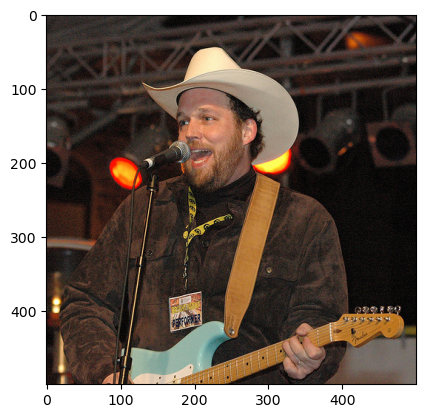

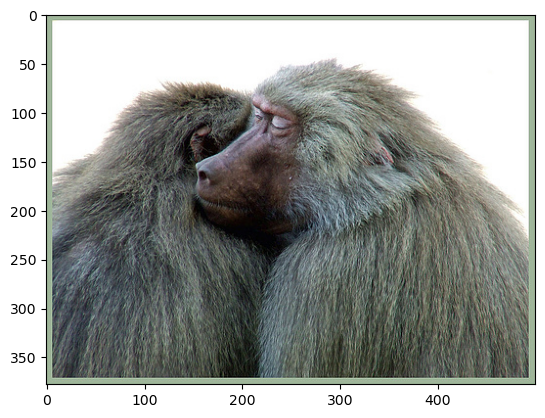

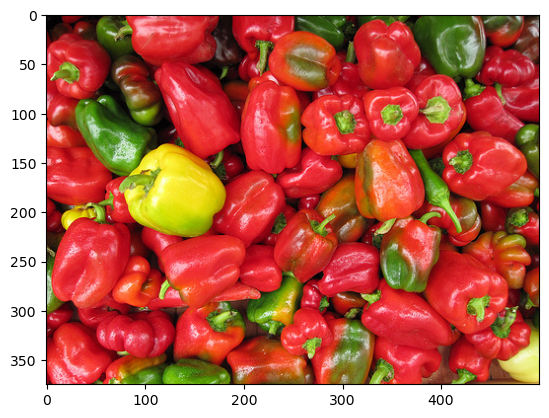

In [47]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.get_image(3150))
plt.show()
plt.imshow(train_dataset.get_image(120))
plt.show()
plt.imshow(train_dataset.get_image(1390))
plt.show()

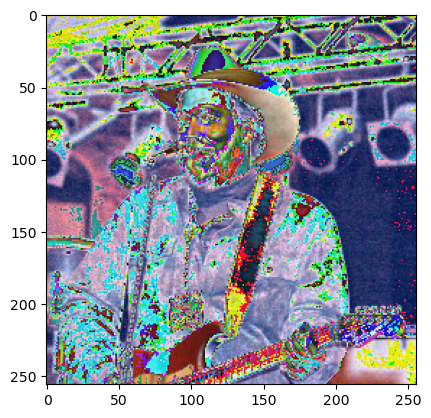

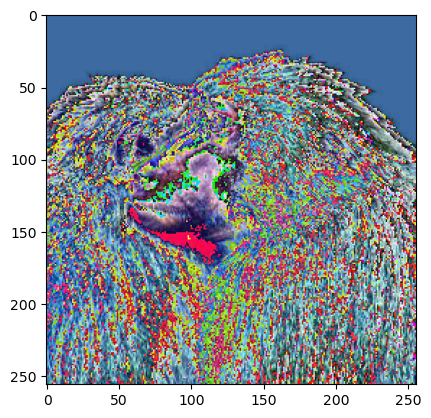

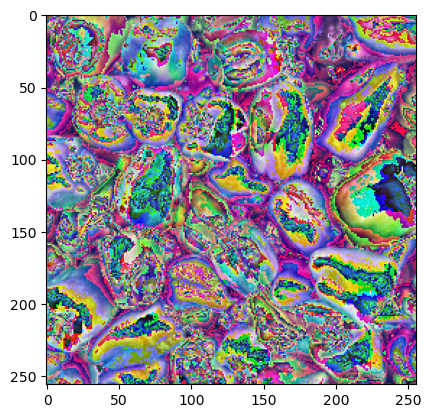

In [48]:
to_pil = transforms.functional.to_pil_image
    
import matplotlib.pyplot as plt
plt.imshow(to_pil(train_dataset[3150]))
plt.show()
plt.imshow(to_pil(train_dataset[120]))
plt.show()
plt.imshow(to_pil(train_dataset[1390]))
plt.show()

In [49]:
def visualize(model, dataset, idxs):
    with torch.no_grad():
        for i in idxs:
            plt.imshow(dataset[i].numpy().transpose(1,2,0))
            plt.show()
            orig_img_on_device = dataset[i].unsqueeze(0).to(device)
            print(orig_img_on_device.count_nonzero())
            decoded_img = model(orig_img_on_device).cpu().detach().squeeze(0)
            plt.imshow(decoded_img.transpose(0, 2))
            plt.show()


def train(model, optimizer, criterion,
          dataloaders: Dict[str, DataLoader], epochs,
          phases: List[str] = ["train", "val"], device = None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()
            else:
                phase_err_msg = 'Phases cannot contain a phase ' \
                                'other than "train" or "val".'
                raise ValueError(phase_err_msg)
            
            epoch_loss = 0

            batch_pbar = tqdm(
                dataloaders[phase],
                total=len(dataloaders[phase]))
                        
            with torch.set_grad_enabled(model.training):
                for img in batch_pbar:
                    img = img.to(device)
                    img_decoded = model(img)

                    loss = criterion(img_decoded, img)
                    epoch_loss += loss

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    progress_string = f"batch mse loss: {loss:.3f}"
                    batch_pbar.set_description(progress_string)
                    # maybe batch_pbar.set_postfix
            
            model.eval()
            visualize(model, train_dataset, idxs = [0])
    model.eval()

In [50]:
def train_model(model, criterion, optimizer, num_epochs=3, phases = ['train', 'val'], history = None):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
    
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_true_labels = []
            all_preds = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.item() / len(datasets[phase])
            epoch_f_score = f1_score(all_true_labels, all_preds, average = 'macro')
            
            if history is not None:
                history[phase]["f_score"].append(epoch_f_score)
                history[phase]["loss"].append(epoch_loss)
                history[phase]["accuracy"].append(epoch_acc)

            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}")
            print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [51]:
dummy_datasets = {"train": train_dataset, "val": train_dataset}
dummy_dataloaders = {
    "train": DataLoader(train_dataset, batch_size = 32, shuffle = True),
    "val": DataLoader(train_dataset, batch_size = 128, shuffle = False)}

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet_autoencoder = create_resnet_autoencoder(
    resnet18(weights=ResNet18_Weights.DEFAULT),
    B = 4).to(device)
# resnet_autoencoder.freeze_encoder()
optimizer = torch.optim.Adam(resnet_autoencoder.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 

epochs = 5

Epoch 1/5
----------


batch mse loss: 1.298:  19%|█▉        | 44/233 [00:29<01:38,  1.92it/s]/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:646: UserWarning: Metadata Warning, tag 33723 had too many entries: 11, expected 1
  warnings.warn(
batch mse loss: 1.008: 100%|██████████| 233/233 [02:11<00:00,  1.77it/s]


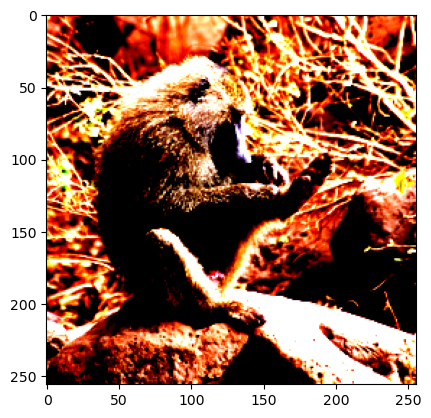

tensor(196608, device='cuda:0')


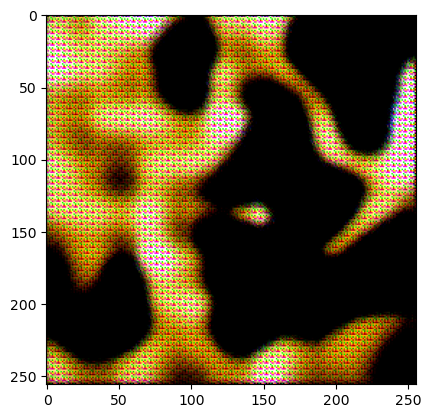

Epoch 2/5
----------


batch mse loss: 1.017: 100%|██████████| 233/233 [01:37<00:00,  2.40it/s]


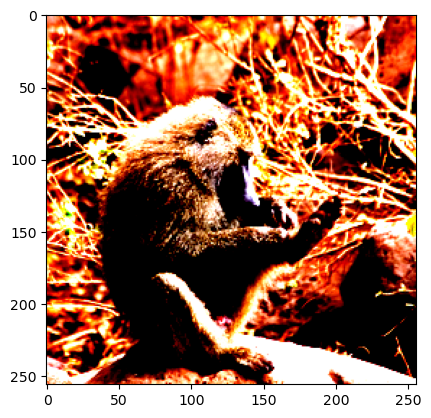

tensor(196608, device='cuda:0')


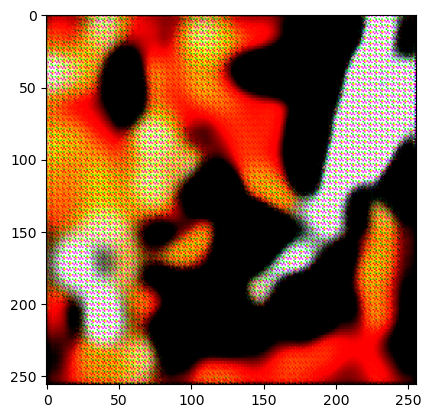

Epoch 3/5
----------


batch mse loss: 0.913: 100%|██████████| 233/233 [01:38<00:00,  2.38it/s]


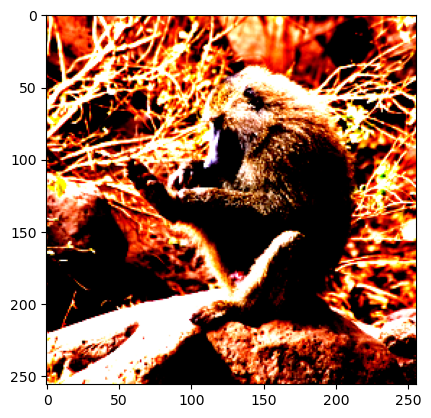

tensor(196608, device='cuda:0')


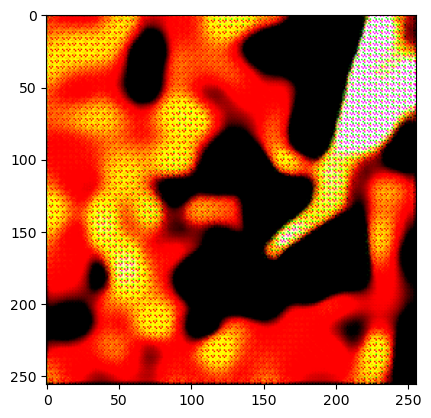

Epoch 4/5
----------


batch mse loss: 0.929: 100%|██████████| 233/233 [01:37<00:00,  2.39it/s]


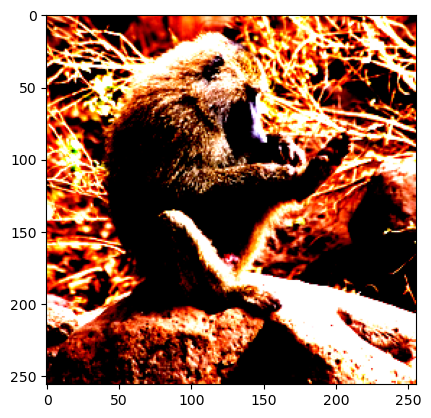

tensor(196608, device='cuda:0')


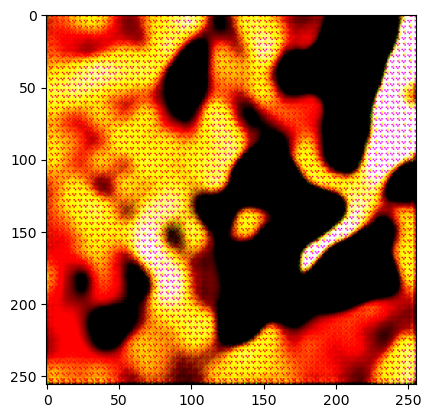

Epoch 5/5
----------


batch mse loss: 0.943: 100%|██████████| 233/233 [01:37<00:00,  2.40it/s]


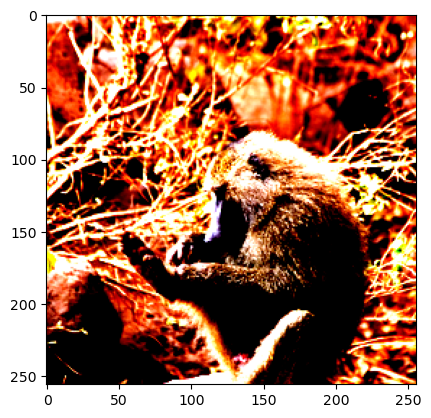

tensor(196608, device='cuda:0')


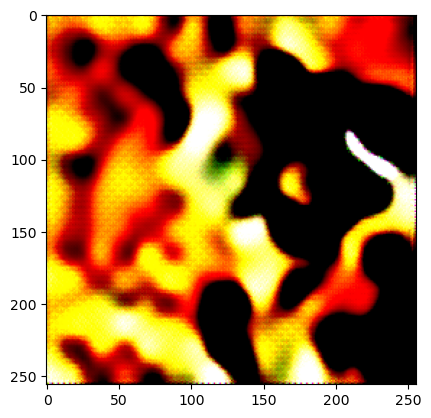

In [53]:
train(resnet_autoencoder, optimizer, criterion, dummy_dataloaders, epochs, phases = ["train"])

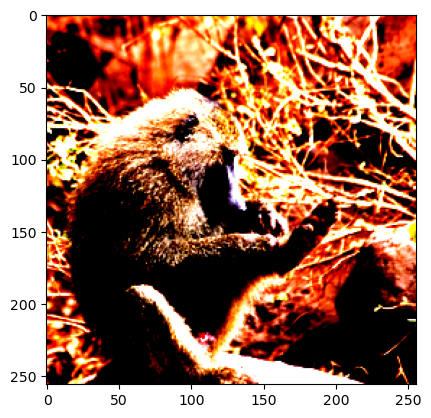

tensor(196608, device='cuda:0')


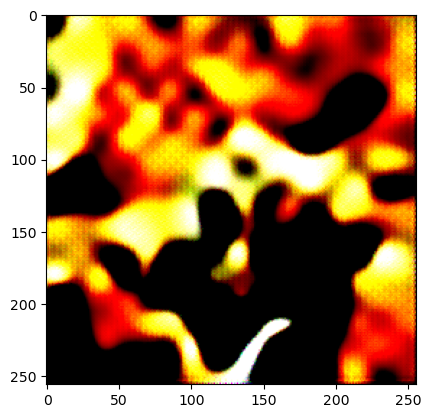

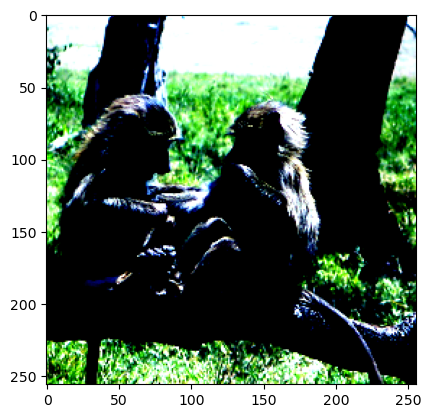

tensor(196608, device='cuda:0')


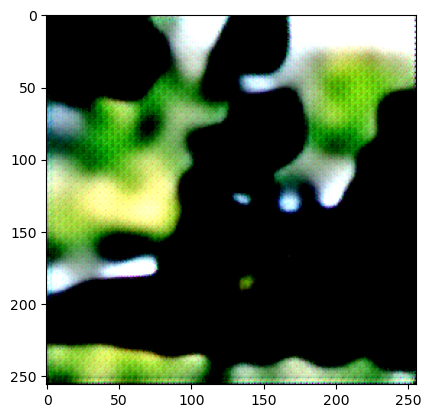

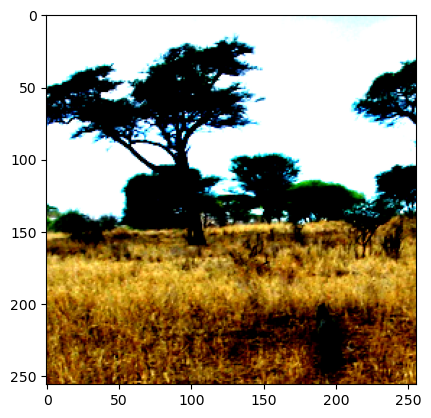

tensor(196608, device='cuda:0')


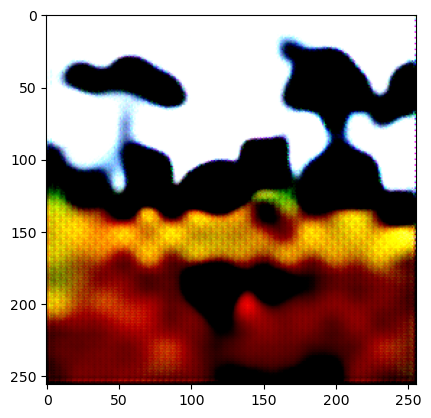

In [54]:
resnet_autoencoder.eval()
with torch.no_grad():
    for i in [0,5, 10]:
        plt.imshow(train_dataset[i].numpy().transpose(1,2,0))
        plt.show()
        orig_img_on_device = train_dataset[i].unsqueeze(0).to(device)
        print(orig_img_on_device.count_nonzero())
        decoded_img = resnet_autoencoder(orig_img_on_device).cpu().detach().squeeze(0)
        plt.imshow(decoded_img.permute(1, 2, 0))
        plt.show()

In [57]:
def denormalize(img: torch.Tensor, means: List[int], stds: List[int]):
    result = torch.zeros_like(img)
    for i, (chan, mean, std) in enumerate(zip(img, means, stds)):
        result[i] = chan * std + mean
    return result


def denormalize_imagenet(img: torch.Tensor):
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    return denormalize(img, imagenet_mean, imagenet_std)

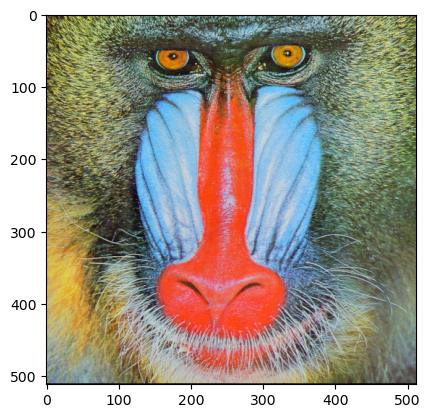

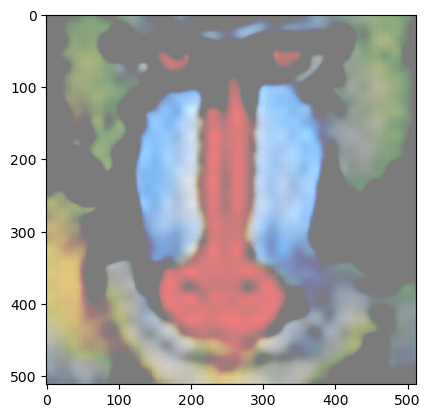

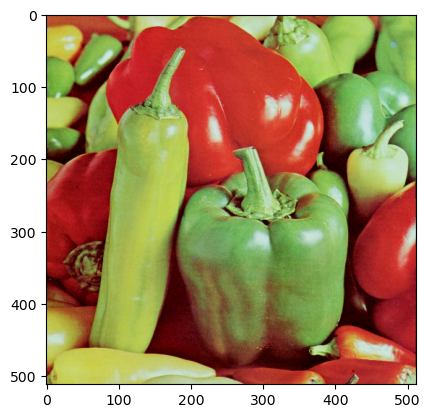

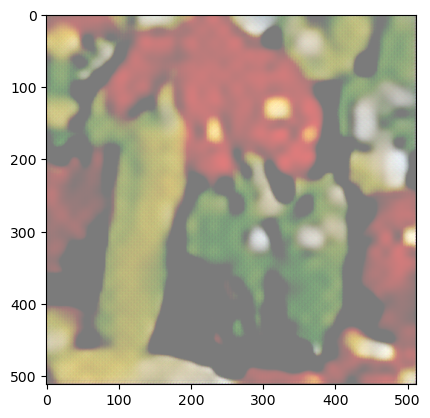

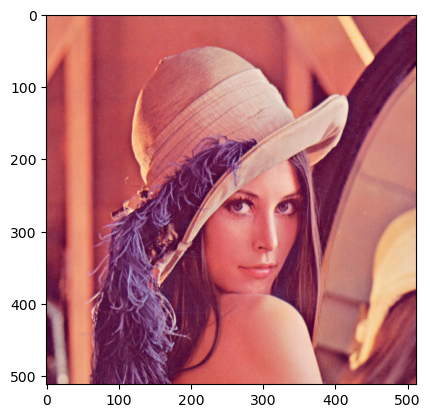

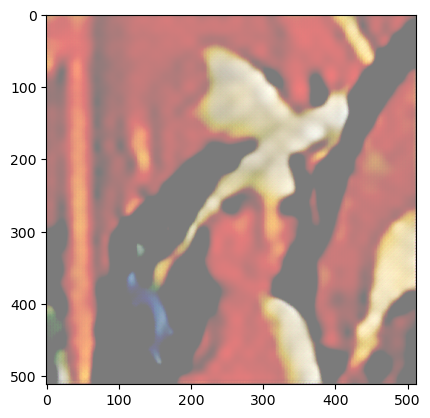

In [58]:
lab_imgs_path = "/kaggle/input/compression-lab-imgs"
for img_name in os.listdir(lab_imgs_path):
    image_path = os.path.join(lab_imgs_path, img_name)
    image = skimage.io.imread(image_path)
    image = Image.fromarray(image)
    image = data_transforms['test'](image)

    orig_img_on_device = image.unsqueeze(0).to(device)
    decoded_img = denormalize_imagenet(
        resnet_autoencoder(orig_img_on_device),
    ).cpu().detach().squeeze(0)
    
    plt.imshow(denormalize_imagenet(image).numpy().transpose(1,2,0))
    plt.show()
    
    plt.imshow(decoded_img.permute(1, 2, 0))
    plt.show()